## Problem Statement 

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [1]:
# !pip install plotly
# !pip install WordCloud
# !pip install spacy
# !python -m spacy download en_core_web_sm
# !pip install nltk


In [2]:
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from pprint import pprint

from nltk.corpus import wordnet, stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.tag import pos_tag
from nltk.util import ngrams
from wordcloud import WordCloud
from collections import Counter

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score

## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [3]:
# Opening JSON file 
f = 'complaints-2021-05-14_08_16.json'
  
# returns JSON object as  
# a dictionary 

try:
    with open(f, 'r') as file:
        data = json.load(file)
    df=pd.json_normalize(data)
    print(df.head())

except:
    print('Please check the file path again. ')

                _index      _type      _id  _score   _source.tags  \
0  complaint-public-v2  complaint  3211475     0.0           None   
1  complaint-public-v2  complaint  3229299     0.0  Servicemember   
2  complaint-public-v2  complaint  3199379     0.0           None   
3  complaint-public-v2  complaint  2673060     0.0           None   
4  complaint-public-v2  complaint  3203545     0.0           None   

  _source.zip_code _source.complaint_id                       _source.issue  \
0            90301              3211475   Attempts to collect debt not owed   
1            319XX              3229299     Written notification about debt   
2            77069              3199379  Other features, terms, or problems   
3            48066              2673060      Trouble during payment process   
4            10473              3203545                    Fees or interest   

       _source.date_received _source.state  ... _source.company_response  \
0  2019-04-13T12:00:00-05:00      

## Data preparation

In [4]:
# Inspect the dataframe to understand the given data.
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  object 
 3   _score                             78313 non-null  float64
 4   _source.tags                       10900 non-null  object 
 5   _source.zip_code                   71556 non-null  object 
 6   _source.complaint_id               78313 non-null  object 
 7   _source.issue                      78313 non-null  object 
 8   _source.date_received              78313 non-null  object 
 9   _source.state                      76322 non-null  object 
 10  _source.consumer_disputed          78313 non-null  object 
 11  _source.product                    78313 non-null  obj

In [5]:
#print the column names
df.columns.to_list()

['_index',
 '_type',
 '_id',
 '_score',
 '_source.tags',
 '_source.zip_code',
 '_source.complaint_id',
 '_source.issue',
 '_source.date_received',
 '_source.state',
 '_source.consumer_disputed',
 '_source.product',
 '_source.company_response',
 '_source.company',
 '_source.submitted_via',
 '_source.date_sent_to_company',
 '_source.company_public_response',
 '_source.sub_product',
 '_source.timely',
 '_source.complaint_what_happened',
 '_source.sub_issue',
 '_source.consumer_consent_provided']

In [6]:
#Assign new column names
df.columns = ['index',
 'type',
 'id',
 'score',
 'tags',
 'zip_code',
 'complaint_id',
 'issue',
 'date_received',
 'state',
 'consumer_disputed',
 'product',
 'company_response',
 'company',
 'submitted_via',
 'date_sent_to_company',
 'company_public_response',
 'sub_product',
 'timely',
 'complaint_what_happened',
 'sub_issue',
 'consumer_consent_provided']

df.head()

,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,...,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


## Insights:  
- The data frame contains 78313 rows and 22 columns.  
- Here we are interested in 'complaint_what_happened' columns only.  
- There are some missing values in it.   
- We have cleaned the data in following steps.

In [7]:
# Assign nan in place of blanks in the complaints column
df['complaint_what_happened'] = df['complaint_what_happened'].replace(r'^\s*$', np.nan, regex=True)
df.head(3)

,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,...,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,NaN,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided


In [8]:
#Remove all rows where complaints column is nan
df = df.dropna(subset=['complaint_what_happened'])
df = df.reset_index()
df.shape

(21072, 23)

## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [9]:
df.head(3)

,level_0,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,...,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided
0,1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
1,2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
2,10,complaint-public-v2,complaint,3233499,0.0,None,104XX,3233499,Incorrect information on your report,2019-05-06T12:00:00-05:00,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-06T12:00:00-05:00,None,Other personal consumer report,Yes,Chase Card was reported on XX/XX/2019. However...,Information belongs to someone else,Consent provided


In [10]:
# Write your function here to clean the text and remove all the unnecessary elements.
# 1. Making text lowercase
df['complaint_what_happened'] = df['complaint_what_happened'].apply(lambda x: x.lower())

# 2. Removing the text in brackets -> {}
df['complaint_what_happened'] = df['complaint_what_happened'].str.replace(r'\{.*?\}', '', regex=True)

# 3. Removing punctuation
df['complaint_what_happened'] = df['complaint_what_happened'].str.replace(r'[^\w\s]', '', regex=True)

# 4. Removing words containing numbers
df['complaint_what_happened'] = df['complaint_what_happened'].str.replace(r'\b\w*\d\w*\b', '', regex=True)

# 5. Removing '_'
df['complaint_what_happened'] = df['complaint_what_happened'].str.replace('_', ' ')

# 6. REmoving extra spaces 
df['complaint_what_happened'] = df['complaint_what_happened'].str.replace(r'\s+', ' ', regex=True)

# 7. Removing the duplicates
df = df.drop_duplicates(subset='complaint_what_happened')



print('After preprocessing, our data set is of shape :  ', df.shape)
print(df['complaint_what_happened'][:5])

After preprocessing, our data set is of shape :   (20873, 23)
0    good morning my name is xxxx xxxx and i apprec...
1    i upgraded my xxxx xxxx card in and was told b...
2    chase card was reported on however fraudulent ...
3    on while trying to book a xxxx xxxx ticket i c...
4    my grand son give me check for i deposit it in...
Name: complaint_what_happened, dtype: object


## Insights:  
- We have cleanned the data.  
- we have removed duplicates, missing values, etc.  
- After cleaning the data, we are left with around 21k complaints.

#### Lemmatizing the text with PoS tagging  
- WordNet Lemmatizer in NLTK defaults to lemmatize the words as nouns.  
- Thats why lemmatizing the text without PoS tagging might not give accurate results.
- Here we are applying lemmatizer with PoS tagging for good results.

In [11]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')
# nltk.download('all')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [12]:
df['complaint_what_happened'].head()

0    good morning my name is xxxx xxxx and i apprec...
1    i upgraded my xxxx xxxx card in and was told b...
2    chase card was reported on however fraudulent ...
3    on while trying to book a xxxx xxxx ticket i c...
4    my grand son give me check for i deposit it in...
Name: complaint_what_happened, dtype: object

In [13]:
#Write your function to Lemmatize the texts
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else :
        return wordnet.NOUN
    

def lemmatize_text(text):
    tokens = word_tokenize(text)
    pos_tags = pos_tag(tokens)
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token, get_wordnet_pos(tag)) for token, tag in pos_tags]
    return ' '.join(lemmatized_tokens)


df['lemmatized_complaint'] = df['complaint_what_happened'].apply(lemmatize_text)

In [14]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 
df_clean = pd.DataFrame({})
df_clean['complaints'] = df['complaint_what_happened']
df_clean['lemmatized_complaints'] = df['lemmatized_complaint']
df_clean.head()

,complaints,lemmatized_complaints
0,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and i apprec...
1,i upgraded my xxxx xxxx card in and was told b...,i upgrade my xxxx xxxx card in and be tell by ...
2,chase card was reported on however fraudulent ...,chase card be report on however fraudulent app...
3,on while trying to book a xxxx xxxx ticket i c...,on while try to book a xxxx xxxx ticket i come...
4,my grand son give me check for i deposit it in...,my grand son give me check for i deposit it in...


In [15]:
#Write your function to extract the POS tags 
# Also removing stop words

def pos_tag_removed_NN_words(text):
  tokens = word_tokenize(text)

  # Removing stop words
  stop_words = set(stopwords.words('english'))
  tokens = [word for word in tokens if word not in stop_words ]

  lemmatized_pos_tag = pos_tag(tokens)
  filtered_tokens = [token for token, tag in lemmatized_pos_tag if tag == 'NN']
  return ' '.join(filtered_tokens)  


df_clean["complaint_POS_removed"] =  df_clean['lemmatized_complaints'].apply(pos_tag_removed_NN_words)

In [16]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean.head()

,complaints,lemmatized_complaints,complaint_POS_removed
0,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and i apprec...,morning name appreciate chase bank cardmember ...
1,i upgraded my xxxx xxxx card in and was told b...,i upgrade my xxxx xxxx card in and be tell by ...,card tell agent date information order upgrade...
2,chase card was reported on however fraudulent ...,chase card be report on however fraudulent app...,card report application submit identity consen...
3,on while trying to book a xxxx xxxx ticket i c...,on while try to book a xxxx xxxx ticket i come...,book ticket come offer apply ticket card infor...
4,my grand son give me check for i deposit it in...,my grand son give me check for i deposit it in...,son check deposit chase account fund bank acco...


## Insights:
- We have used text lemmatizer, POS tagging and removed all the words other than 'NN' tags.

## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




c:\Users\user\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



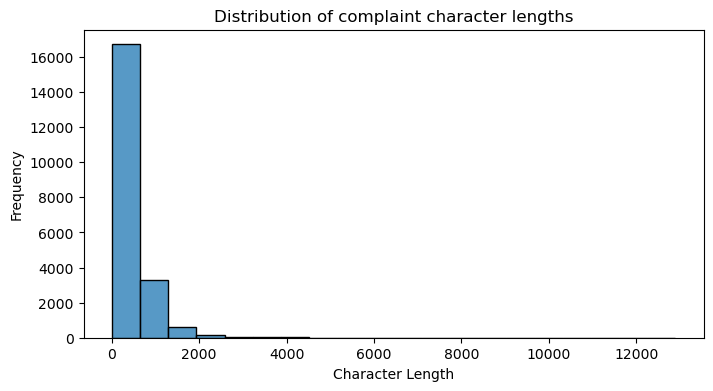

In [17]:
# Write your code here to visualise the data according to the 'Complaint' character length
df_clean['character_length'] = df_clean['complaint_POS_removed'].apply(len)
plt.figure(figsize=(8,4))
sns.histplot(df_clean['character_length'], bins=20)
plt.title('Distribution of complaint character lengths')
plt.xlabel('Character Length')
plt.ylabel('Frequency')
plt.show()

In [18]:
df_clean.head()

,complaints,lemmatized_complaints,complaint_POS_removed,character_length
0,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and i apprec...,morning name appreciate chase bank cardmember ...,175
1,i upgraded my xxxx xxxx card in and was told b...,i upgrade my xxxx xxxx card in and be tell by ...,card tell agent date information order upgrade...,105
2,chase card was reported on however fraudulent ...,chase card be report on however fraudulent app...,card report application submit identity consen...,81
3,on while trying to book a xxxx xxxx ticket i c...,on while try to book a xxxx xxxx ticket i come...,book ticket come offer apply ticket card infor...,405
4,my grand son give me check for i deposit it in...,my grand son give me check for i deposit it in...,son check deposit chase account fund bank acco...,169


#### Find the top 40 words by frequency among all the articles after processing the text.

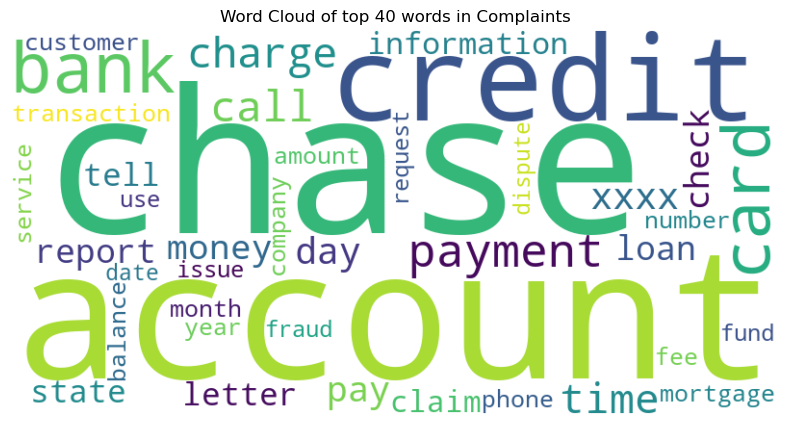

In [19]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
word_counts = {}

# Tokenize the text and counting word frequency
for text in df_clean['complaint_POS_removed']:
    words = word_tokenize(text)
    for word in words:
        word_counts[word] = word_counts.get(word, 0) + 1

# selecting top 40 words
top_words = dict(sorted(word_counts.items(), key=lambda item: item[1], reverse=True)[ : 40])

# Generating word cloud
wordcloud = WordCloud(width = 800, height=400, background_color='white').generate_from_frequencies(top_words)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of top 40 words in Complaints')
plt.show()

In [20]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')
df_clean.head()

,complaints,lemmatized_complaints,complaint_POS_removed,character_length,Complaint_clean
0,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and i apprec...,morning name appreciate chase bank cardmember ...,175,morning name appreciate chase bank cardmember ...
1,i upgraded my xxxx xxxx card in and was told b...,i upgrade my xxxx xxxx card in and be tell by ...,card tell agent date information order upgrade...,105,card tell agent date information order upgrade...
2,chase card was reported on however fraudulent ...,chase card be report on however fraudulent app...,card report application submit identity consen...,81,card report application submit identity consen...
3,on while trying to book a xxxx xxxx ticket i c...,on while try to book a xxxx xxxx ticket i come...,book ticket come offer apply ticket card infor...,405,book ticket come offer apply ticket card infor...
4,my grand son give me check for i deposit it in...,my grand son give me check for i deposit it in...,son check deposit chase account fund bank acco...,169,son check deposit chase account fund bank acco...


#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [21]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean). 

# Concatinating all complaints into single string
all_complaints = ' '.join(df_clean['Complaint_clean'])
tokens = word_tokenize(all_complaints)

# Count the frequency of each unigram
unigram_freq = Counter(tokens)

# Top 30 most common unigram
top_30_unigrams = unigram_freq.most_common(30)

In [22]:
#Print the top 10 words in the unigram frequency
for word in top_30_unigrams[:10]:
    print(word[0])

chase
account
credit
bank
card
payment
call
charge
time
xxxx


In [23]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean). 
bigram_list = list(ngrams(tokens, 2))
bigram_freq = Counter(bigram_list)

top_30_bigrams = bigram_freq.most_common(30)

In [24]:
#Print the top 10 words in the bigram frequency
for word in top_30_bigrams[:10]:
    print(word[0])

('credit', 'card')
('chase', 'bank')
('credit', 'report')
('call', 'chase')
('customer', 'service')
('chase', 'credit')
('check', 'account')
('bank', 'account')
('account', 'chase')
('chase', 'account')


In [25]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean). 
trigram_list = list(ngrams(tokens, 3))
trigram_freq = Counter(trigram_list)

top_30_trigrams = trigram_freq.most_common(30)

In [26]:
#Print the top 10 words in the trigram frequency
for word in top_30_trigrams[:10]:
    print(word[0])

('chase', 'credit', 'card')
('credit', 'card', 'company')
('credit', 'card', 'account')
('credit', 'card', 'chase')
('chase', 'customer', 'service')
('charge', 'credit', 'card')
('credit', 'card', 'credit')
('call', 'customer', 'service')
('inquiry', 'credit', 'report')
('credit', 'report', 'credit')


## Insight:  
- Most of the complaints are of less than 2000 characters. (short complaints)  
- Very few complains are having large character length.(lengthy complaints)    
- We have printed top 40 words in all the complaints using word cloud.  
- Also top 10 words of unigram, bigram, trigram is printed.

## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [27]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

In [28]:
#All masked texts has been removed
df_clean

,complaints,lemmatized_complaints,complaint_POS_removed,character_length,Complaint_clean
0,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and i apprec...,morning name appreciate chase bank cardmember ...,175,morning name appreciate chase bank cardmember ...
1,i upgraded my xxxx xxxx card in and was told b...,i upgrade my xxxx xxxx card in and be tell by ...,card tell agent date information order upgrade...,105,card tell agent date information order upgrade...
2,chase card was reported on however fraudulent ...,chase card be report on however fraudulent app...,card report application submit identity consen...,81,card report application submit identity consen...
3,on while trying to book a xxxx xxxx ticket i c...,on while try to book a xxxx xxxx ticket i come...,book ticket come offer apply ticket card infor...,405,book ticket come offer apply ticket card infor...
4,my grand son give me check for i deposit it in...,my grand son give me check for i deposit it in...,son check deposit chase account fund bank acco...,169,son check deposit chase account fund bank acco...
...,...,...,...,...,...
21067,after being a chase card customer for well ove...,after be a chase card customer for well over a...,chase card customer decade offer solicitation ...,236,chase card customer decade offer solicitation ...
21068,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx i call chas my xxxx xxxx...,call chas xxxx credit card provider claim purc...,706,call chas credit card provider claim purchase...
21069,i am not familiar with xxxx pay and did not un...,i be not familiar with xxxx pay and do not und...,pay risk consumer chase bank chase year trust ...,677,pay risk consumer chase bank chase year trust ...
21070,i have had flawless credit for yrs ive had cha...,i have have flawless credit for yrs ive have c...,flawless credit chase credit card chase freedo...,557,flawless credit chase credit card chase freedo...


## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [29]:
#Write your code here to initialise the TfidfVectorizer 
vectorizer = TfidfVectorizer(stop_words='english', max_df=0.95, min_df=2)

#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [30]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
tfidf_matrix = vectorizer.fit_transform(df_clean['Complaint_clean'])

# Converting TF-IDF matrix into data frame for better readability
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())

print(tfidf_df.head())

    aa  aarp   ab  aback  abandon  abandonment  abatement  abbreviation  abd  \
0  0.0   0.0  0.0    0.0      0.0          0.0        0.0           0.0  0.0   
1  0.0   0.0  0.0    0.0      0.0          0.0        0.0           0.0  0.0   
2  0.0   0.0  0.0    0.0      0.0          0.0        0.0           0.0  0.0   
3  0.0   0.0  0.0    0.0      0.0          0.0        0.0           0.0  0.0   
4  0.0   0.0  0.0    0.0      0.0          0.0        0.0           0.0  0.0   

   abet  ...  youth  youve   yr  yrs  ytd  zero  zip  zombie  zone  zoom  
0   0.0  ...    0.0    0.0  0.0  0.0  0.0   0.0  0.0     0.0   0.0   0.0  
1   0.0  ...    0.0    0.0  0.0  0.0  0.0   0.0  0.0     0.0   0.0   0.0  
2   0.0  ...    0.0    0.0  0.0  0.0  0.0   0.0  0.0     0.0   0.0   0.0  
3   0.0  ...    0.0    0.0  0.0  0.0  0.0   0.0  0.0     0.0   0.0   0.0  
4   0.0  ...    0.0    0.0  0.0  0.0  0.0   0.0  0.0     0.0   0.0   0.0  

[5 rows x 7149 columns]


In [31]:
tfidf_df.sum()

aa         0.389412
aarp       3.893046
ab         0.347604
aback      1.011741
abandon    2.763016
             ...   
zero       7.731249
zip        8.724625
zombie     0.685883
zone       2.785069
zoom       0.438623
Length: 7149, dtype: float64

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

In [32]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [33]:
#Load your nmf_model with the n_components i.e 5
num_topics = 5

#keep the random_state =40
nmf_model = NMF(n_components=num_topics, random_state=40)

In [34]:
nmf_model.fit(tfidf_matrix)
len(vectorizer.get_feature_names_out())

7149

In [35]:
#Print the Top15 words for each of the topics

words = np.array(vectorizer.get_feature_names_out())
topic_words = pd.DataFrame(np.zeros((5, 15)), index=[f'Topic {i + 1}' for i in range(5)],
                           columns=[f'Word {i + 1}' for i in range(15)]).astype(str)
for i in range(5):
    ix = nmf_model.components_[i].argsort()[::-1][:15]
    topic_words.iloc[i] = words[ix]

topic_words

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15
Topic 1,account,bank,check,money,chase,deposit,fund,day,branch,transaction,tell,number,transfer,claim,business
Topic 2,credit,card,report,inquiry,chase,account,company,score,information,bureau,debt,limit,letter,application,year
Topic 3,loan,mortgage,home,chase,modification,property,year,letter,rate,time,house,sale,foreclosure,document,request
Topic 4,charge,fee,card,dispute,chase,transaction,purchase,merchant,claim,refund,fraud,pay,service,statement,balance
Topic 5,payment,pay,balance,month,statement,fee,day,auto,time,date,chase,credit,account,year,mortgage


In [36]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4

df_clean['Topic'] = nmf_model.transform(tfidf_matrix).argmax(axis=1)
df_clean.head()

,complaints,lemmatized_complaints,complaint_POS_removed,character_length,Complaint_clean,Topic
0,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and i apprec...,morning name appreciate chase bank cardmember ...,175,morning name appreciate chase bank cardmember ...,0
1,i upgraded my xxxx xxxx card in and was told b...,i upgrade my xxxx xxxx card in and be tell by ...,card tell agent date information order upgrade...,105,card tell agent date information order upgrade...,1
2,chase card was reported on however fraudulent ...,chase card be report on however fraudulent app...,card report application submit identity consen...,81,card report application submit identity consen...,1
3,on while trying to book a xxxx xxxx ticket i c...,on while try to book a xxxx xxxx ticket i come...,book ticket come offer apply ticket card infor...,405,book ticket come offer apply ticket card infor...,1
4,my grand son give me check for i deposit it in...,my grand son give me check for i deposit it in...,son check deposit chase account fund bank acco...,169,son check deposit chase account fund bank acco...,0


In [37]:
#Print the first 5 Complaint for each of the Topics
df_clean1 =df_clean.groupby('Topic').head(5)
df_clean1.sort_values('Topic')

,complaints,lemmatized_complaints,complaint_POS_removed,character_length,Complaint_clean,Topic
0,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and i apprec...,morning name appreciate chase bank cardmember ...,175,morning name appreciate chase bank cardmember ...,0
4,my grand son give me check for i deposit it in...,my grand son give me check for i deposit it in...,son check deposit chase account fund bank acco...,169,son check deposit chase account fund bank acco...,0
6,with out notice jp morgan chase restricted my ...,with out notice jp morgan chase restrict my ac...,jp restrict account debit card tuesday thursda...,572,jp restrict account debit card tuesday thursda...,0
10,mishandling of this account by chase auto and ...,mishandling of this account by chase auto and ...,account auto xxxx,17,account auto,0
12,i opened an account with chase bank on xxxx an...,i open an account with chase bank on xxxx and ...,account bank xxxx use code bonus call term tel...,137,account bank use code bonus call term tell ev...,0
1,i upgraded my xxxx xxxx card in and was told b...,i upgrade my xxxx xxxx card in and be tell by ...,card tell agent date information order upgrade...,105,card tell agent date information order upgrade...,1
2,chase card was reported on however fraudulent ...,chase card be report on however fraudulent app...,card report application submit identity consen...,81,card report application submit identity consen...,1
3,on while trying to book a xxxx xxxx ticket i c...,on while try to book a xxxx xxxx ticket i come...,book ticket come offer apply ticket card infor...,405,book ticket come offer apply ticket card infor...,1
5,can you please remove inquiry,can you please remove inquiry,inquiry,7,inquiry,1
9,i have a chase credit card which is incorrectl...,i have a chase credit card which be incorrectl...,chase credit card credit report company issue,45,chase credit card credit report company issue,1


#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [38]:
#Create the dictionary of Topic names and Topics
Topic_names = {  0: 'Bank account services',
                 1: 'Credit card / Prepaid card',
                 2: 'Mortgages/loans', 
                 3: 'Theft/Dispute reporting',
                 4: 'Others'}
#Replace Topics with Topic Names
df_clean['Topic_names'] = df_clean['Topic'].map(Topic_names)

In [39]:
df_clean.head()


,complaints,lemmatized_complaints,complaint_POS_removed,character_length,Complaint_clean,Topic,Topic_names
0,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and i apprec...,morning name appreciate chase bank cardmember ...,175,morning name appreciate chase bank cardmember ...,0,Bank account services
1,i upgraded my xxxx xxxx card in and was told b...,i upgrade my xxxx xxxx card in and be tell by ...,card tell agent date information order upgrade...,105,card tell agent date information order upgrade...,1,Credit card / Prepaid card
2,chase card was reported on however fraudulent ...,chase card be report on however fraudulent app...,card report application submit identity consen...,81,card report application submit identity consen...,1,Credit card / Prepaid card
3,on while trying to book a xxxx xxxx ticket i c...,on while try to book a xxxx xxxx ticket i come...,book ticket come offer apply ticket card infor...,405,book ticket come offer apply ticket card infor...,1,Credit card / Prepaid card
4,my grand son give me check for i deposit it in...,my grand son give me check for i deposit it in...,son check deposit chase account fund bank acco...,169,son check deposit chase account fund bank acco...,0,Bank account services


## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [88]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data = df_clean[['complaints', 'Topic']]
training_data.head(), training_data.shape

(                                          complaints  Topic
 0  good morning my name is xxxx xxxx and i apprec...      0
 1  i upgraded my xxxx xxxx card in and was told b...      1
 2  chase card was reported on however fraudulent ...      1
 3  on while trying to book a xxxx xxxx ticket i c...      1
 4  my grand son give me check for i deposit it in...      0,
 (20873, 2))

#### Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [89]:
#Write your code to get the Vector count
count_vector = CountVectorizer(stop_words='english')
x_counts = count_vector.fit_transform(training_data['complaints'])

#Write your code here to transform the word vector to tf-idf
Tfidf_Vectorizer1 = TfidfTransformer()
tfidf_matrix_training = Tfidf_Vectorizer1.fit_transform(x_counts)

# Converting TF-IDF matrix into data frame for better readability
tfidf_df_training = pd.DataFrame(tfidf_matrix_training.toarray(), columns=Tfidf_Vectorizer1.get_feature_names_out())
print(tfidf_df_training.head())


    x0   x1   x2   x3   x4   x5   x6   x7   x8   x9  ...  x33294  x33295  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...     0.0     0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...     0.0     0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...     0.0     0.0   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...     0.0     0.0   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...     0.0     0.0   

   x33296  x33297  x33298  x33299  x33300  x33301  x33302  x33303  
0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0  
1     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0  
2     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0  
3     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0  
4     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0  

[5 rows x 33304 columns]


In [90]:
# Train test split of tfidf matrix
X_train, X_test, y_train, y_test = train_test_split(tfidf_matrix_training, training_data['Topic'], test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((16698, 33304), (4175, 33304), (16698,), (4175,))

You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

### Logistic Regression 

In [91]:
results = []

In [92]:
# Logistic Regression Model 
log_reg = LogisticRegression(solver='saga',
                            multi_class='multinomial',
                            max_iter=1000,
                            n_jobs=-1)

log_reg.fit(X_train, y_train)

LogisticRegression(max_iter=1000, multi_class='multinomial', n_jobs=-1,
                   solver='saga')

In [93]:
y_train_pred = log_reg.predict(X_train)
print('Training data : ')
print('Accuracy score = ', accuracy_score(y_train, y_train_pred))
print('confusion matrix = \n', confusion_matrix(y_train, y_train_pred), '\n')
print('Classification Report = \n', classification_report(y_train, y_train_pred), '\n')
print('-'*60, '\n')

y_test_pred = log_reg.predict(X_test)
print('Testing data : ')
print('Accuracy score = ', accuracy_score(y_test, y_test_pred))
print('confusion matrix = \n', confusion_matrix(y_test, y_test_pred), '\n')
print('Classification Report = \n', classification_report(y_test, y_test_pred), '\n')

results.append({'Model Name' : 'Logistic Regression',
                'Train Accuracy ' : accuracy_score(y_train, y_train_pred),
                'Test Accuracy' : accuracy_score(y_test, y_test_pred)})


Training data : 
Accuracy score =  0.976164810156905
confusion matrix = 
 [[4255   28    8   32    3]
 [  27 3901    5   44    3]
 [  22   21 3035    8    3]
 [  56   31   17 3427    3]
 [  26   23   22   16 1682]] 

Classification Report = 
               precision    recall  f1-score   support

           0       0.97      0.98      0.98      4326
           1       0.97      0.98      0.98      3980
           2       0.98      0.98      0.98      3089
           3       0.97      0.97      0.97      3534
           4       0.99      0.95      0.97      1769

    accuracy                           0.98     16698
   macro avg       0.98      0.97      0.98     16698
weighted avg       0.98      0.98      0.98     16698
 

------------------------------------------------------------ 

Testing data : 
Accuracy score =  0.9295808383233533
confusion matrix = 
 [[1008   29   11   17    4]
 [  18  980    9   25    6]
 [  19   11  675    4    4]
 [  30   25    9  837    4]
 [  17   16   20 

### Decision Tree

In [94]:
# Decision Tree Model 
decision_tree = DecisionTreeClassifier(
    max_depth=10,
    min_samples_leaf=5,
    min_samples_split=5,
    random_state=42
)

decision_tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=10, min_samples_leaf=5, min_samples_split=5,
                       random_state=42)

In [95]:
y_train_pred = decision_tree.predict(X_train)
print('Training data : ')
print('Accuracy score = ', accuracy_score(y_train, y_train_pred))
print('confusion matrix = \n', confusion_matrix(y_train, y_train_pred), '\n')
print('Classification Report = \n', classification_report(y_train, y_train_pred), '\n')
print('-'*60, '\n')

y_test_pred = decision_tree.predict(X_test)
print('Testing data : ')
print('Accuracy score = ', accuracy_score(y_test, y_test_pred))
print('confusion matrix = \n', confusion_matrix(y_test, y_test_pred), '\n')
print('Classification Report = \n', classification_report(y_test, y_test_pred), '\n')

results.append({'Model Name' : 'Decision Tree',
                'Train Accuracy ' : accuracy_score(y_train, y_train_pred),
                'Test Accuracy' : accuracy_score(y_test, y_test_pred)})

Training data : 
Accuracy score =  0.825128757935082
confusion matrix = 
 [[3640  116  351  179   40]
 [ 251 3255  181  262   31]
 [ 200   85 2673   86   45]
 [ 289  164  295 2738   48]
 [  82   63   95   57 1472]] 

Classification Report = 
               precision    recall  f1-score   support

           0       0.82      0.84      0.83      4326
           1       0.88      0.82      0.85      3980
           2       0.74      0.87      0.80      3089
           3       0.82      0.77      0.80      3534
           4       0.90      0.83      0.86      1769

    accuracy                           0.83     16698
   macro avg       0.83      0.83      0.83     16698
weighted avg       0.83      0.83      0.83     16698
 

------------------------------------------------------------ 

Testing data : 
Accuracy score =  0.7774850299401198
confusion matrix = 
 [[860  37  92  70  10]
 [ 73 815  38  90  22]
 [ 39  24 604  19  27]
 [ 84  75  87 635  24]
 [ 31  27  40  20 332]] 

Classificat

### Random Forest

In [96]:
params = {
     'n_estimators': [50, 75, 100],
    'max_depth': [10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

random_forest = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(estimator=random_forest,
                           param_grid=params,
                           scoring='accuracy',
                           cv=5,
                           verbose=2,
                           n_jobs=-1)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [10, 15, 20],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 75, 100]},
             scoring='accuracy', verbose=2)

In [97]:
best_parameters = grid_search.best_params_
best_estimator = grid_search.best_estimator_

print('Best parameters = ', best_parameters)

Best parameters =  {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}


In [98]:
y_train_pred = best_estimator.predict(X_train)
print('Training data : ')
print('Accuracy score = ', accuracy_score(y_train, y_train_pred))
print('confusion matrix = \n', confusion_matrix(y_train, y_train_pred), '\n')
print('Classification Report = \n', classification_report(y_train, y_train_pred), '\n')
print('-'*60, '\n')

y_test_pred = best_estimator.predict(X_test)
print('Testing data : ')
print('Accuracy score = ', accuracy_score(y_test, y_test_pred))
print('confusion matrix = \n', confusion_matrix(y_test, y_test_pred), '\n')
print('Classification Report = \n', classification_report(y_test, y_test_pred), '\n')

results.append({'Model Name' : 'Random Forest',
                'Train Accuracy ' : accuracy_score(y_train, y_train_pred),
                'Test Accuracy' : accuracy_score(y_test, y_test_pred)})

Training data : 
Accuracy score =  0.8411785842615882
confusion matrix = 
 [[4157  148    7   14    0]
 [ 121 3752    8   99    0]
 [ 170  265 2634   19    1]
 [ 296  230   15 2993    0]
 [ 379  460  282  138  510]] 

Classification Report = 
               precision    recall  f1-score   support

           0       0.81      0.96      0.88      4326
           1       0.77      0.94      0.85      3980
           2       0.89      0.85      0.87      3089
           3       0.92      0.85      0.88      3534
           4       1.00      0.29      0.45      1769

    accuracy                           0.84     16698
   macro avg       0.88      0.78      0.79     16698
weighted avg       0.86      0.84      0.83     16698
 

------------------------------------------------------------ 

Testing data : 
Accuracy score =  0.7659880239520958
confusion matrix = 
 [[980  66   5  18   0]
 [ 60 901   4  72   1]
 [ 53  74 579   6   1]
 [124  90   6 685   0]
 [106 137 111  43  53]] 

Classifica

### Naive Bayes Model

In [99]:
naive_bayes = MultinomialNB()
naive_bayes.fit(X_train, y_train)

MultinomialNB()

In [100]:
y_train_pred = naive_bayes.predict(X_train)
print('Training data : ')
print('Accuracy score = ', accuracy_score(y_train, y_train_pred))
print('confusion matrix = \n', confusion_matrix(y_train, y_train_pred), '\n')
print('Classification Report = \n', classification_report(y_train, y_train_pred), '\n')
print('-'*60, '\n')

y_test_pred = naive_bayes.predict(X_test)
print('Testing data : ')
print('Accuracy score = ', accuracy_score(y_test, y_test_pred))
print('confusion matrix = \n', confusion_matrix(y_test, y_test_pred), '\n')
print('Classification Report = \n', classification_report(y_test, y_test_pred), '\n')

results.append({'Model Name' : 'Naive Bayes',
                'Train Accuracy ' : accuracy_score(y_train, y_train_pred),
                'Test Accuracy' : accuracy_score(y_test, y_test_pred)})

Training data : 
Accuracy score =  0.7759611929572404
confusion matrix = 
 [[4124  148   17   37    0]
 [ 372 3336   25  247    0]
 [ 286  223 2542   38    0]
 [ 526  169   30 2809    0]
 [ 522  541  361  199  146]] 

Classification Report = 
               precision    recall  f1-score   support

           0       0.71      0.95      0.81      4326
           1       0.76      0.84      0.79      3980
           2       0.85      0.82      0.84      3089
           3       0.84      0.79      0.82      3534
           4       1.00      0.08      0.15      1769

    accuracy                           0.78     16698
   macro avg       0.83      0.70      0.68     16698
weighted avg       0.81      0.78      0.74     16698
 

------------------------------------------------------------ 

Testing data : 
Accuracy score =  0.7396407185628743
confusion matrix = 
 [[988  60   6  15   0]
 [111 835   6  86   0]
 [ 78  62 565   8   0]
 [164  53  11 677   0]
 [137 133 108  49  23]] 

Classifica

## Results

In [101]:
results_df = pd.DataFrame(results)
print(results_df)

            Model Name  Train Accuracy   Test Accuracy
0  Logistic Regression         0.976165       0.929581
1        Decision Tree         0.825129       0.777485
2        Random Forest         0.841179       0.765988
3          Naive Bayes         0.775961       0.739641


## Insights:
- logistic Regression is giving best results among all models.  
- For Logistic regression, accuracy score on train data = 97 %, and on test data = 92 %.   
- Decision tree, Random forest, Naive Bayes models are giving similar accuracy on train and test data.  

## Final Best Model : Logistic Regression

In [102]:
# Sample test data
sample_test_data = ['I have applied for new credit card in last month, but I still did not receive it yet.',
                    'My prepaid card was declined multiple times despite having a sufficient balance. This happened during a crucial transaction, causing me significant embarrassment and inconvenience. When I contacted customer service, they were unable to provide a clear explanation and did not offer any immediate resolution',
                    "I applied for a personal loan, and despite being pre-approved and submitting all required documentation promptly, the processing of my loan has been excessively delayed. The lack of communication and transparency from the loan officer has been extremely frustrating, as I urgently need the funds for a medical emergency.",
                    "I disputed a charge on my credit card that I did not authorize, but my credit card company has repeatedly denied my claim without providing a valid reason. Despite providing all necessary documentation and evidence, my dispute remains unresolved, and I am being held responsible for a charge I did not make.",
                    "My direct deposits are consistently delayed, sometimes by several days. This inconsistency has caused me to miss important payment deadlines and incur late fees. When I reached out to the bank, they provided no clear explanation or solution for this ongoing issue."]

# Transforming the word vector to tfidf 
x_sample = count_vector.transform(sample_test_data)
tfidf_sample = Tfidf_Vectorizer1.transform(x_sample)

# Prediction using Logistic regression model
y_sample = log_reg.predict(tfidf_sample)

sample_test_data_prediction = pd.DataFrame({
    'Test Sample Complaints' : sample_test_data,
    'Category' : y_sample
})
sample_test_data_prediction['Category'] = sample_test_data_prediction['Category'].map(lambda x: Topic_names[x])
sample_test_data_prediction

,Test Sample Complaints,Category
0,I have applied for new credit card in last mon...,Credit card / Prepaid card
1,My prepaid card was declined multiple times de...,Theft/Dispute reporting
2,"I applied for a personal loan, and despite bei...",Mortgages/loans
3,I disputed a charge on my credit card that I d...,Theft/Dispute reporting
4,"My direct deposits are consistently delayed, s...",Others


## Inferences:
- Our best model in this case is Logistoic Regression.  
- We have taken the sample complaints data from each category -  'Bank account services', 'Credit card / Prepaid card', 'Mortgages/loans', 'Theft/Dispute reporting', 'Others'.  
- We have converted the text data into tfidf and passed to logistic regression model for the classification.  
- Model is giving accurate results for the sample test data